![image.png](https://impact.stanford.edu/sites/default/files/styles/og_image/public/2022-11/facts%20fake%20news%20stock.jpeg?itok=tzHVd3R1)

With the growing spread of misinformation online, detecting fake news has become a critical challenge. This project aims to build a binary text classification model to distinguish between real and fake news articles using natural language processing and deep learning techniques. The dataset includes titles, full texts, subjects, and dates for both fake and real news samples. By training on this data, the model will learn to identify linguistic patterns that signal fake content, helping automate misinformation detection.

### Main tools

In [29]:
!pip install contractions -q

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
from wordcloud import WordCloud
import nltk
from collections import Counter
import contractions
from tqdm import tqdm


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split



nltk.download('stopwords')
from nltk.corpus import stopwords

# Assuming you already have `df` (combined Fake and Real data)
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analayis

Combine df of fake and real datasets together.

In [31]:
# Load datasets
fake_df = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")
real_df = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")

In [32]:
fake_df['label'] = 0
real_df['label'] = 1


df = pd.concat([fake_df, real_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Combine title and text
df['combined_text'] = df['title'] + " " + df['text']

Clean text

In [33]:
def clean_text(text):
    text = contractions.fix(text)                         # Expand contractions
    text = text.encode("ascii", errors="ignore").decode() # Remove non-ASCII chars
    text = text.lower()                                   # Lowercase
    text = re.sub(r"http\S+|www.\S+", "", text)           # Remove URLs
    text = re.sub(r"<.*?>", "", text)                     # Remove HTML tags
    text = re.sub(r"[^a-z\s]", "", text)                  # Keep only letters and spaces
    text = re.sub(r"\b\w{1}\b", "", text)                 # Remove single-letter words
    text = re.sub(r"\s+", " ", text).strip()              # Remove extra spaces
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return " ".join(words)



In [34]:
df['clean_text'] = df['combined_text'].apply(clean_text)
df[['clean_text', 'label']].head()

,clean_text,label
0,ben stein calls th circuit court committed cou...,0
1,trump drops steve bannon national security cou...,1
2,puerto rico expects yous lift jones act shippi...,1
3,oops trump accidentally confirmed leaked israe...,0
4,donald trump heads scotland reopen golf resort...,1


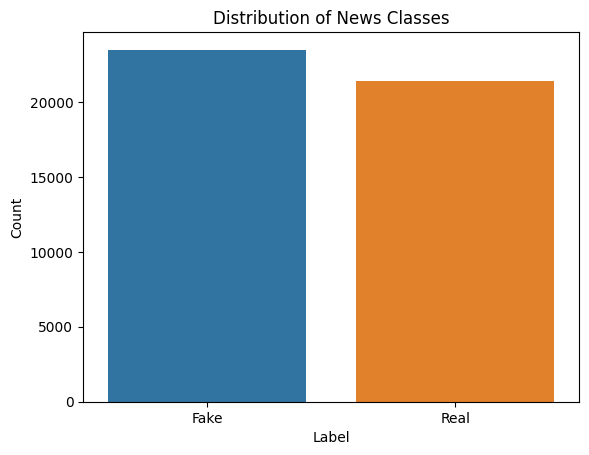

In [35]:
sns.countplot(x="label", data=df)
plt.xticks([0, 1], ["Fake", "Real"])
plt.title("Distribution of News Classes")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


As shown in the plot above, we do not need to use data balancing techniques, as the the data is already has a good balance.

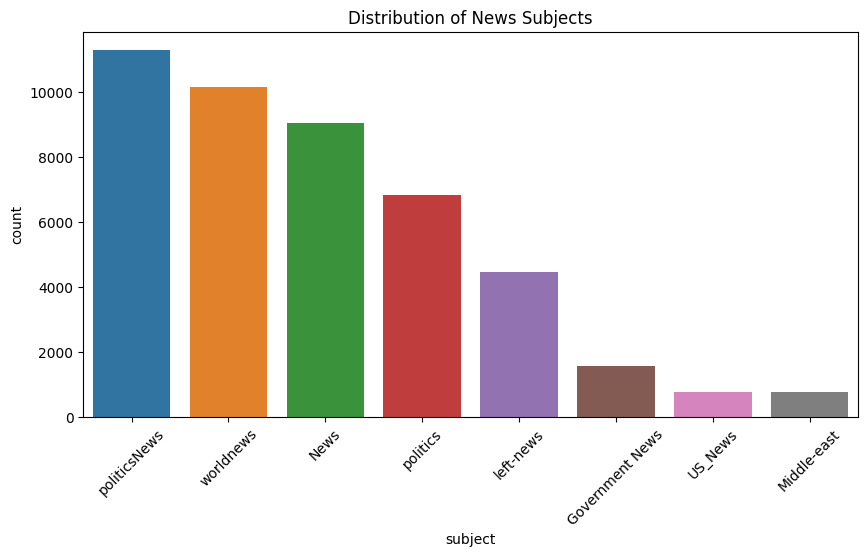

In [36]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="subject", order=df["subject"].value_counts().index)
plt.title("Distribution of News Subjects")
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


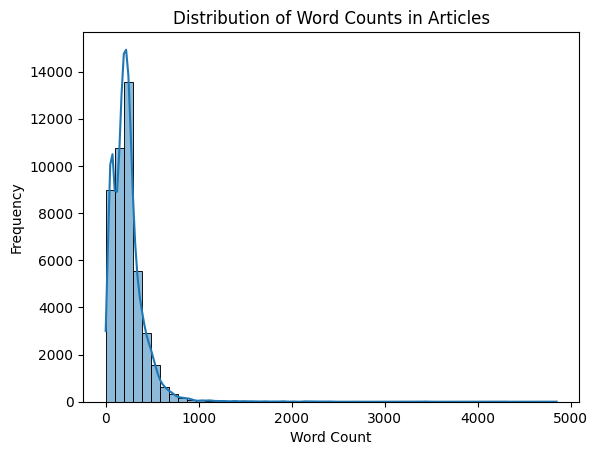

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


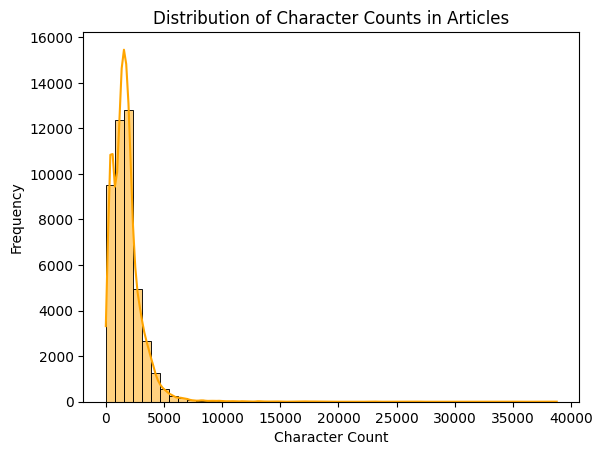

In [37]:
df["text_length"] = df["clean_text"].apply(lambda x: len(x.split()))
df["char_length"] = df["clean_text"].apply(len)

# Word count
sns.histplot(df["text_length"], bins=50, kde=True)
plt.title("Distribution of Word Counts in Articles")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# Character count
sns.histplot(df["char_length"], bins=50, kde=True, color='orange')
plt.title("Distribution of Character Counts in Articles")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.show()


Final Data Frame

In [38]:
df

,title,text,subject,date,label,combined_text,clean_text,text_length,char_length
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein calls th circuit court committed cou...,109,802
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1,Trump drops Steve Bannon from National Securit...,trump drops steve bannon national security cou...,472,3613
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expects yous lift jones act shippi...,182,1347
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0,OOPS: Trump Just Accidentally Confirmed He Le...,oops trump accidentally confirmed leaked israe...,114,943
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1,Donald Trump heads for Scotland to reopen a go...,donald trump heads scotland reopen golf resort...,305,2278
...,...,...,...,...,...,...,...,...,...
44893,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,,politics,"Mar 27, 2017",0,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,unreal cbss ted koppel tells sean hannity bad ...,10,59
44894,PM May seeks to ease Japan's Brexit fears duri...,LONDON/TOKYO (Reuters) - British Prime Ministe...,worldnews,"August 29, 2017",1,PM May seeks to ease Japan's Brexit fears duri...,pm may seeks ease japans brexit fears trade vi...,429,3224
44895,Merkel: Difficult German coalition talks can r...,BERLIN (Reuters) - Chancellor Angela Merkel sa...,worldnews,"November 16, 2017",1,Merkel: Difficult German coalition talks can r...,merkel difficult german coalition talks reach ...,45,341
44896,Trump Stole An Idea From North Korean Propaga...,Jesus f*cking Christ our President* is a moron...,News,"July 14, 2017",0,Trump Stole An Idea From North Korean Propaga...,trump stole idea north korean propaganda parod...,480,3279


## Text Tokenization

I found out that a simple tokenizer using space will do the job without needing to download a tokenizers like Bert.

In [39]:
tokenized_texts = [text.split() for text in df['clean_text']]

In [40]:
# Build vocabulary
word_counter = Counter(word for tokens in tokenized_texts for word in tokens)
vocab_size = 10000  # Limit vocab size
most_common = word_counter.most_common(vocab_size - 2)

In [41]:
# Create word-to-index mappings
word2idx = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1
idx2word = {idx: word for word, idx in word2idx.items()}


## Dataset Preparation

In [42]:
# Function to convert tokens to indices
def encode(tokens, word2idx, max_len):
    ids = [word2idx.get(word, word2idx["<UNK>"]) for word in tokens]
    if len(ids) < max_len:
        ids += [word2idx["<PAD>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

In [43]:
max_len = 300
encoded_texts = [encode(tokens, word2idx, max_len) for tokens in tokenized_texts]
labels = df['label'].values

In [44]:
# Create the custom dataset
class NewsDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = torch.tensor(inputs, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]


Split the dataset into Train, Val and Test splits.

In [45]:
# Step 1: First split → train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    encoded_texts, labels, test_size=0.30, random_state=42, stratify=labels
)

# Step 2: Split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)


In [46]:
# Create datasets
train_dataset = NewsDataset(X_train, y_train)
val_dataset   = NewsDataset(X_val, y_val)
test_dataset  = NewsDataset(X_test, y_test)

In [47]:
train_dataset[0]

(tensor([4420, 1918,   39,  516,   35,   88, 9491,  127,   70,    3, 2898,   24,
            8,  413, 1348,  306,   70,    3,  412, 1918,  965,  127,   70,   14,
            3, 3105,  132,    1,    1,  934,    1,  757,  826,   38,  706, 2618,
           19,  318,   86,  115, 2090,   36, 1174,    1, 3299,    3,  909,  353,
          465, 1596,   38, 1334,   32,    1,  350,   27,   34,    1, 6685,  111,
          374,  411,  227,   39,   24,   22,   16, 2678,  432,    5,  750,   64,
            7,   50,  589,  153,   22,   16,    1,    2,   78, 4546,  219,    1,
          295,  560,   56,  476,   55,   90,  997,  182, 3458,   70,    3,  153,
         1549,   58,  412,  757, 3127,   88,   15,    1, 2240,  300, 2017,  135,
          836, 1767,  685, 4673, 3268,  477,  801,    1, 5532,  412, 1711,  709,
           61,   15,  580,  745, 2952,   30,   35,  934,  125,   10,   11, 1091,
          469, 1347,  135,  169, 1217, 2188,  745,    6,  258, 1711,   42,   11,
           15,  685,    1,  

In [48]:
# Create data loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Choose the model

In [49]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128, num_layers=1, dropout=0.5, bidirectional=True):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        lstm_out, _ = self.lstm(embedded)  # lstm_out: [batch_size, seq_len, hidden_dim * num_directions]
        # Take last hidden state (can use mean or max pooling too)
        last_hidden = lstm_out[:, -1, :]  # [batch_size, hidden_dim * num_directions]
        out = self.dropout(last_hidden)
        out = self.fc(out)
        return self.sigmoid(out).squeeze()


In [50]:
model = LSTMClassifier(
    vocab_size=len(word2idx),
    embedding_dim=100,
    hidden_dim=128,
    num_layers=1,
    dropout=0.5,
    bidirectional=True
)


In [51]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [52]:
model = model.to(device)

## Model training

In [53]:
# Loss function
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [54]:
num_epochs = 10

In [55]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct, total = 0, 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

        preds = (outputs >= 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress bar
        loop.set_postfix(loss=loss.item())

    train_acc = correct / total
    avg_train_loss = train_loss / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        val_loop = tqdm(val_loader, desc="Validation", leave=False)
        for inputs, labels in val_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            preds = (outputs >= 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_loop.set_postfix(val_loss=loss.item())

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / val_total

    # Epoch summary
    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


[Epoch 1] Train Loss: 0.6358 | Train Acc: 0.6155 | Val Loss: 0.6554 | Val Acc: 0.5627


[Epoch 2] Train Loss: 0.6384 | Train Acc: 0.5954 | Val Loss: 0.6781 | Val Acc: 0.5506


[Epoch 3] Train Loss: 0.6500 | Train Acc: 0.5774 | Val Loss: 0.3775 | Val Acc: 0.8722


[Epoch 4] Train Loss: 0.4149 | Train Acc: 0.8176 | Val Loss: 0.3858 | Val Acc: 0.8214


[Epoch 5] Train Loss: 0.3595 | Train Acc: 0.8421 | Val Loss: 0.3613 | Val Acc: 0.8310


[Epoch 6] Train Loss: 0.3965 | Train Acc: 0.8135 | Val Loss: 0.4304 | Val Acc: 0.7887


[Epoch 7] Train Loss: 0.3842 | Train Acc: 0.8217 | Val Loss: 0.3982 | Val Acc: 0.8162


[Epoch 8] Train Loss: 0.3153 | Train Acc: 0.8677 | Val Loss: 0.2524 | Val Acc: 0.8677


[Epoch 9] Train Loss: 0.1731 | Train Acc: 0.9384 | Val Loss: 0.0510 | Val Acc: 0.9877


[Epoch 10] Train Loss: 0.0440 | Train Acc: 0.9917 | Val Loss: 0.0335 | Val Acc: 0.9926


# Model Evaluation.

In [56]:
def evaluate_model(model, dataloader, device, title="Confusion Matrix"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            preds = (outputs >= 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute evaluation metrics
    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec  = recall_score(all_labels, all_preds)
    f1   = f1_score(all_labels, all_preds)

    print(f"Evaluation Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()


✅ Evaluation Metrics:
Accuracy : 0.9932
Precision: 0.9922
Recall   : 0.9935
F1 Score : 0.9928


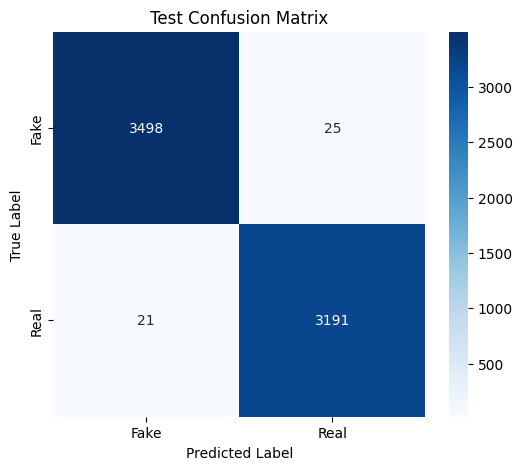

In [57]:
evaluate_model(model, test_loader, device, title="Test Confusion Matrix")


So, after reaching a very high accuracy, we should save the model.

## Save the model

In [58]:
torch.save(model, 'model.pt')

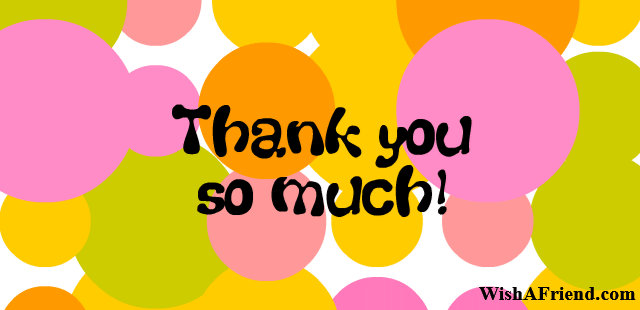!